In [1]:
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
import netCDF4
import pickle
import cftime
import matplotlib


SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
#constants
path='/storage/jlavoie/Research/Data/Budget/'
fTEMP=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.pop.h.TEMP.200601-208012.nc')
fTEMP1=Dataset(path+'b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.TEMP.192001-200512.nc')
faice=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.cice.h.aice_nh.200601-208012.nc')


months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
nbDaysInMonth=[31,28,31,30,31,30,31,31,30,31,30,31]

rho_sw=fTEMP['rho_sw'][:]*1000#kg m-3
cp_sw=fTEMP['cp_sw'][:]*0.0001#J kg-1 K-1
T2E=rho_sw*cp_sw#J degC-1 m-3
latent_heat_vapor=fTEMP['latent_heat_vapor'][:]
latent_heat_fusion=fTEMP1['latent_heat_fusion'][:]*1e-7*1000# erg/g -> J/kg
rho_ice=917#kg/m3

dz=fTEMP['dz'][:]*0.01# m
dzw=fTEMP['dzw'][:]*0.01# m
Tf=-1.8
tlong=fTEMP['TLONG'][:]
tlat=fTEMP['TLAT'][:]
tlon=faice['TLON'][:]
tla=faice['TLAT'][:]
z_t=fTEMP['z_t'][:]*0.01#m
z_w=fTEMP['z_w'][:]*0.01#m
z_w_top=fTEMP['z_w_top'][:]*0.01#m
z_w_bot=fTEMP['z_w_bot'][:]*0.01#m


timeDay1=fTEMP1['time']
Jan1920=cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, 0, 0)
time1 = netCDF4.num2date(timeDay1[:],timeDay1.units,calendar=timeDay1.calendar)
time1=[Jan1920]+list(time1[:-1])
time_boundDay1=fTEMP1['time_bound']
time_bound1 = netCDF4.num2date(time_boundDay1[:],timeDay1.units,calendar=timeDay1.calendar)
ind1970, ind1980= 600,720

timeDay=fTEMP['time']
time = netCDF4.num2date(timeDay[:],timeDay.units,calendar=timeDay.calendar)
#fix month error in cesm
Jan2006=cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, 0, 0)
time=[Jan2006]+list(time[:-1])
time_boundDay=fTEMP['time_bound']
time_bound = netCDF4.num2date(time_boundDay[:],timeDay.units,calendar=timeDay.calendar)
ind2010=12*4
ind2020=12*14




# create mask CB
maskCBocn=np.zeros((384,320))
for i in range(384):
    for j in range(320):
        if  205<=tlong[i,j]<=230 and 72<=tlat[i,j]<=80:
            maskCBocn[i,j]=1
            
maskCBice=np.zeros((104,320))
for i in range(104):
    for j in range(320):
        if  205<=tlon[i,j]<=230 and 72<=tla[i,j]<=80:
            maskCBice[i,j]=1


pathSaved='/storage/jlavoie/Research/Data/saved/'
with open(pathSaved+"ajProfiles.txt", "rb") as fp:  
    ajProfiles=pickle.load(fp)
print('ajloaded!')
with open(pathSaved+"itpProfiles.txt", "rb") as fp:  
    itpProfiles=pickle.load(fp)
print('itploaded!')
z_O=ajProfiles[0]['D']


ajloaded!
itploaded!


In [3]:
pathCESM='/storage/jlavoie/Research/Data/CESM-LE/'

#list of string with numberof EM
EM=['00'+str(i) if i<10 else  '0'+str(i) if i<100 else ' '   for i in range(1,36)] +[str(i) for i in range(101,106)]
#cesm variable needed to calculate the flux of element of the budget
varByPro={'D':['DIA_IMPVF_TEMP','KPP_SRC_TEMP','HDIFB_TEMP','MELTH_F'],'A':['WTT'],'R':['QSW_3D','SHF','SHF_QSW','QFLUX','MELTH_F'],'dEdt':['TEMP']}

In [4]:
"""
#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std
transport_40=[{'D':[],'A':[],'R':[],'dEdt':[],'D_dia':[],'D_nl':[],'D_h':[],'Fio':[]},{'D':[],'A':[],'R':[],'dEdt':[],'D_dia':[],'D_nl':[],'D_h':[],'Fio':[]}]

transportMean=[]
transportStd=[]
transportMax=[]
transportMin=[]

blockNans=np.zeros((120, 249, 60))
blockNans[blockNans==0]=np.nan
t=3
timeBD=time_boundDay[(12*t)+11:(12*t)+25]# get time for right window
DeltaTime=[(x[1]-x[0])*86400 for x in timeBD]# nb of days in the months and put in sec

for p in range(2):# iterate between 2 periods
    if p==0:
        indA,indB=ind1970,ind1980
        run='B20TRC5CNBDRD'

        
    else:
        indA,indB=ind2010,ind2020
        run='BRCP85C5CNBDRD'
        
    for em in EM[1::]:
        print(em)
        for f in ['A','dEdt','R','D']:
            varNeeded=[]
            for var in varByPro[f]:
                #specifics of filename
                model='pop'
                varHemi=var
                if var[0].islower():
                    model='cice'
                    varHemi=var+'_nh'#add hemisphere for name of file
                push1920=0
                if p==0:
                    if em=='001':
                        date='185001-200512'
                        push1920=840#push index to start at 1920 not 1850
                    else:
                        date='192001-200512'          
                else:
                    if int(em)>=34 and p==1:
                        date='200601-210012'
                    else:
                        date='200601-208012'
                fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
                if var[0].islower():# ice var
                    cutVar=fileEM[var][indA+push1920:indB+push1920]# cut like this because it is faster
                    varNeeded.append(cutVar[:,maskCBice==1])
                elif var in ['MELTH_F','SHF','SHF_QSW','QFLUX']:# 2d not 3d
                    cutVar=fileEM[var][indA+push1920:indB+push1920,-104:]# cut like this because it is faster
                    varNeeded.append(cutVar[:,maskCBice==1])
                elif var =='TEMP':
                    cutVar=fileEM[var][indA+push1920-1:indB+push1920+1,:,-104:]# cut like this because it is faster
                    varNeeded.append(cutVar[:,:,maskCBice==1])
                else:# ocean var 3d
                    cutVar=fileEM[var][indA+push1920:indB+push1920,:,-104:]# cut like this because it is faster
                    varNeeded.append(cutVar[:,:,maskCBice==1])

        
            
            if f=='dEdt':
                data_CB_all=np.zeros((10,12,249,60))
                for t in range(10):
                    # T to E
                    TEMP_CB_all=np.swapaxes(varNeeded[0][(12*t):(12*t)+14],1,2)
                    E_1=TEMP_CB_all*T2E
                    E_1[E_1>1e30]=np.nan

                    #dE/dt
                    wAvgTemp=[((E_1[i]*DeltaTime[i]) + (E_1[i+1]*DeltaTime[i+1]))/(DeltaTime[i]+DeltaTime[i+1]) for i in range(13)]
                    dEdt=np.array([(wAvgTemp[i]-wAvgTemp[i-1])/DeltaTime[i] for i in range(1,13)])
                    data_CB_all[t,:,:,:]=dEdt
                data_CB_all=np.swapaxes(data_CB_all,0,1)
            elif f=='A':
                # vertical advection term with WTT 
                WTT_1=np.swapaxes(varNeeded[0],1,2)
                WTT_1[abs(WTT_1)>1e30]=np.nan
                # add line of 0 at the bottom to keep dim (12,249,60)
                Adv_1=blockNans.copy()
                Adv_1[:,:,:-1]=-np.diff(WTT_1,axis=2)# negative because direction of diif is down but W+ is up
                data_CB_all=np.array([(-Adv_1*T2E)[m::12] for m in range(12)])# minus by defintion
            elif f=='R':
                #external fluxes
                #penetrating sw
                QSW_3D_1=np.swapaxes(varNeeded[0],1,2)#watt/m^2
                QSW_3D_1[abs(QSW_3D_1)>1e30]=np.nan
                QSW_3D_1_z=blockNans.copy()  # add line of nans at the bottom to keep dim (12,249,60) instead of 59
                QSW_3D_1_z[:,:,:-1]=-np.diff(QSW_3D_1)/dz[:-1]#  also - because going down
                #other fluxes
                Fother_1=np.zeros((120, 249, 60))
                Fother_1[:,:,0]=(varNeeded[1]
                                -varNeeded[2]
                                 +varNeeded[3]
                                -varNeeded[4])/dz[0]
                Fother_1[abs(Fother_1)>1e30]=np.nan
                data_CB_all=np.array([(QSW_3D_1_z + Fother_1)[m::12] for m in range(12)])
            elif f=='D':
                #vertical diffusion from TEMP Flux Across Bottom Face from Diabatic Implicit Vertical Mixing
                DIA_IMPVF_TEMP_1=np.zeros((120, 249, 61))# add line of 0 at the top to be in z_w instead of z_w_bot
                DIA_IMPVF_TEMP_1[:,:,1:]=np.swapaxes(varNeeded[0]/100,1,2) #degC m s-1 
                DIA_IMPVF_TEMP_1[abs(DIA_IMPVF_TEMP_1)>1e30]=np.nan
                DIA_IMPVF_TEMP_z_1=np.array([(-np.diff(DIA_IMPVF_TEMP_1)/dz*T2E)[m::12] for m in range(12)])# neg. diff towards bottom #degC s-1


                #vm from non local KPP
                nonLocalTerm=np.array([(np.swapaxes(varNeeded[1],1,2)*T2E)[m::12] for m in range(12)])

                #flux through bottom face from MG param (horizontal diff)
                HDIFB_TEMP_1=np.zeros((120, 249, 61))# add line of 0 at the top to be in z_w instead of z_w_bot
                HDIFB_TEMP_1[:,:,1:]=np.swapaxes(varNeeded[2],1,2)
                HDIFB_TEMP_1[abs(HDIFB_TEMP_1)>1e30]=np.nan
                HDIFB_TEMP_z_1=np.array([(-np.diff(HDIFB_TEMP_1)*T2E)[m::12] for m in range(12)])# neg. diff towards bottom #degC s-1


                #turbulent ice-ocean flux
                Fio=np.zeros((12,10, 249, 60))
                Fio[:,:,:,0]=[(varNeeded[3]/dz[0])[m::12] for m in range(12)]

                #sum
                data_CB_all=DIA_IMPVF_TEMP_z_1+nonLocalTerm+HDIFB_TEMP_z_1+Fio
                transport_40[p]['D_dia'].append(np.nanmean(DIA_IMPVF_TEMP_z_1,axis=(1,2)))
                transport_40[p]['D_nl'].append(np.nanmean(nonLocalTerm,axis=(1,2)))
                transport_40[p]['D_h'].append(np.nanmean(HDIFB_TEMP_z_1,axis=(1,2)))
                transport_40[p]['Fio'].append(np.nanmean(Fio,axis=(1,2)))

            
            transport_40[p][f].append(np.nanmean(data_CB_all,axis=(1,2)))
        

    
    for f in transport_40[p]:
        transport_40[p][f]=np.array(transport_40[p][f])
        
    transport_40[p]['residual']=(transport_40[p]['dEdt']
                    -(transport_40[p]['R']+transport_40[p]['D']+transport_40[p]['A']))

    meanP={}
    stdP={}
    maxP={}
    minP={}
    for f in transport_40[p]:
        meanP[f]=np.nanmean(transport_40[p][f],axis=0)
        stdP[f]=np.nanstd(transport_40[p][f],axis=0)
        maxP[f]=np.nanmax(transport_40[p][f],axis=0)
        minP[f]=np.nanmin(transport_40[p][f],axis=0)
    transportMean.append(meanP)
    transportStd.append(stdP)
    transportMax.append(maxP)
    transportMin.append(minP)

    """

"\n#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std\ntransport_40=[{'D':[],'A':[],'R':[],'dEdt':[],'D_dia':[],'D_nl':[],'D_h':[],'Fio':[]},{'D':[],'A':[],'R':[],'dEdt':[],'D_dia':[],'D_nl':[],'D_h':[],'Fio':[]}]\n\ntransportMean=[]\ntransportStd=[]\ntransportMax=[]\ntransportMin=[]\n\nblockNans=np.zeros((120, 249, 60))\nblockNans[blockNans==0]=np.nan\nt=3\ntimeBD=time_boundDay[(12*t)+11:(12*t)+25]# get time for right window\nDeltaTime=[(x[1]-x[0])*86400 for x in timeBD]# nb of days in the months and put in sec\n\nfor p in range(2):# iterate between 2 periods\n    if p==0:\n        indA,indB=ind1970,ind1980\n        run='B20TRC5CNBDRD'\n\n        \n    else:\n        indA,indB=ind2010,ind2020\n        run='BRCP85C5CNBDRD'\n        \n    for em in EM[1::]:\n        print(em)\n        for f in ['A','dEdt','R','D']:\n            varNeeded=[]\n            for var in varByPro[f]:\n                #specifics of filename\n                model='pop'\n

In [5]:
"""
with open('saved/transportMean.pickle', 'wb') as handle:
    pickle.dump(transportMean, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('saved/transportStd.pickle', 'wb') as handle:
    pickle.dump(transportStd, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved/transportMax.pickle', 'wb') as handle:
    pickle.dump(transportMax, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('saved/transportMin.pickle', 'wb') as handle:
    pickle.dump(transportMin, handle, protocol=pickle.HIGHEST_PROTOCOL)

"""

with open('saved/transportMean.pickle', 'rb') as handle:
    transportMean = pickle.load(handle)

with open('saved/transportStd.pickle', 'rb') as handle:
    transportStd = pickle.load(handle)
with open('saved/transportMax.pickle', 'rb') as handle:
    transportMax = pickle.load(handle)

with open('saved/transportMin.pickle', 'rb') as handle:
    transportMin = pickle.load(handle)


In [6]:
with open('saved/CESMmean.pickle', 'rb') as handle:
    CESMmean = pickle.load(handle)

with open('saved/CESMstd.pickle', 'rb') as handle:
    CESMstd = pickle.load(handle)
with open('saved/CESMmax.pickle', 'rb') as handle:
    CESMmax = pickle.load(handle)

with open('saved/CESMmin.pickle', 'rb') as handle:
    CESMmin = pickle.load(handle)

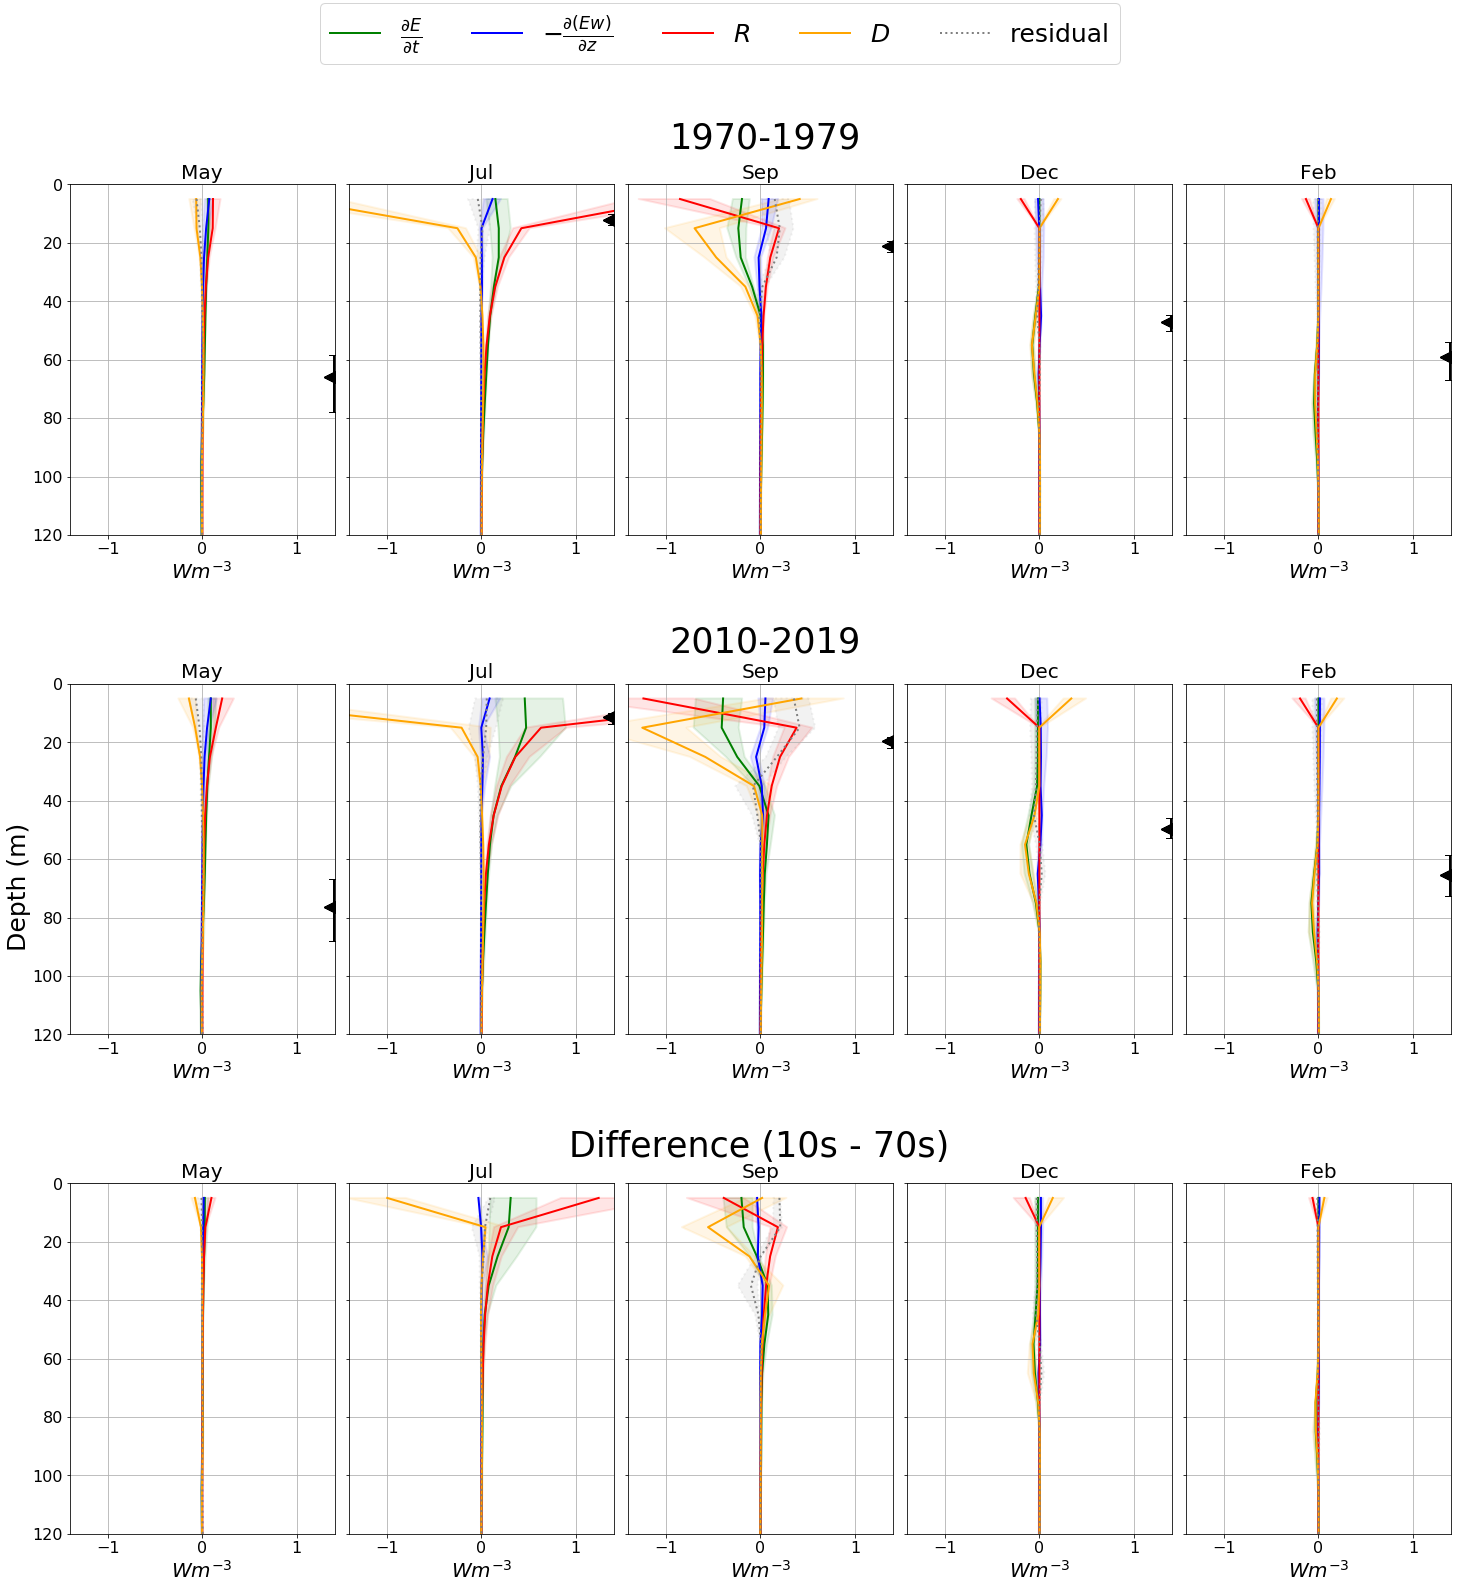

In [7]:
# 70s,10s, diff. 5 months

ylim=(120,0)
xlim=(-1.4,1.4)#
lw=2
alpha=0.1
fig, axs = plt.subplots(3, 5, figsize=(20,20),sharey=True)
x=0
terms=['dEdt','A','R','D','residual']
labels=[r'$\frac{\partial  E}{\partial t}$',r'$-\frac{\partial ( E w)}{\partial z}$',r'$ R$',r'$D$','residual']
colors=['green','blue','red','orange','grey']
linestyle=['-','-','-','-',':']

for monthInd in [4,6,8,11,1]:
    for f, label,c,ls in zip(terms,labels,colors,linestyle):
        for p in range(2):
            y=p
            axs[y][x].set_xlabel(r'$W m^{-3}$')

            axs[y][x].plot(transportMean[p][f][monthInd],z_t,color=c,linewidth=lw,linestyle=ls,
                           label=label if monthInd==1 and p==0 else None)
            axs[y][x].fill_betweenx(z_t,transportMin[p][f][monthInd],transportMax[p][f][monthInd],color=c
                                    ,linewidth=lw,linestyle=ls,alpha=alpha)

            axs[y][x].errorbar(xlim[1]-0.01,CESMmean[p]['MLD'][monthInd],yerr=
                               np.reshape([(CESMmean[p]['MLD'][monthInd]-CESMmin[p]['MLD'][monthInd]),
                                (CESMmax[p]['MLD'][monthInd]-CESMmean[p]['MLD'][monthInd])], (2,1))
                               ,fmt='<',color='black',markersize=20,capsize=5)
            axs[y][x].set_xlim(xlim)
            axs[y][x].grid(axis='both')
            axs[y][x].set_title(months[monthInd],fontsize=20)

        #difference
        y=2
        axs[y][x].plot(transportMean[1][f][monthInd]-transportMean[0][f][monthInd],z_t,color=c,
                       linewidth=lw,linestyle=ls)
        axs[y][x].fill_betweenx(z_t,transportMin[1][f][monthInd]-transportMin[0][f][monthInd],
                       transportMax[1][f][monthInd]-transportMax[0][f][monthInd],color=c,
                       linewidth=lw,linestyle=ls,alpha=alpha)
        axs[y][x].set_xlabel(r'$W m^{-3}$')    
        axs[y][x].set_xlim(xlim)
        axs[y][x].grid(axis='both')
        axs[y][x].set_title(months[monthInd],fontsize=20)


    x+=1
fig.legend(ncol=6,bbox_to_anchor=(0.5,1.08),loc='center',fontsize=25)
plt.gca().invert_yaxis()
plt.ylim(ylim)
fig.text(-0.01, 0.49, 'Depth (m)', va='center', rotation='vertical',fontsize=25)
fig.text(0.45, 0.66, '2010-2019', va='center',fontsize=35)
fig.text(0.45, 1.01, '1970-1979', va='center',fontsize=35)
fig.text(0.38, 0.31, 'Difference (10s - 70s)', va='center',fontsize=35)



fig.tight_layout(h_pad=8)


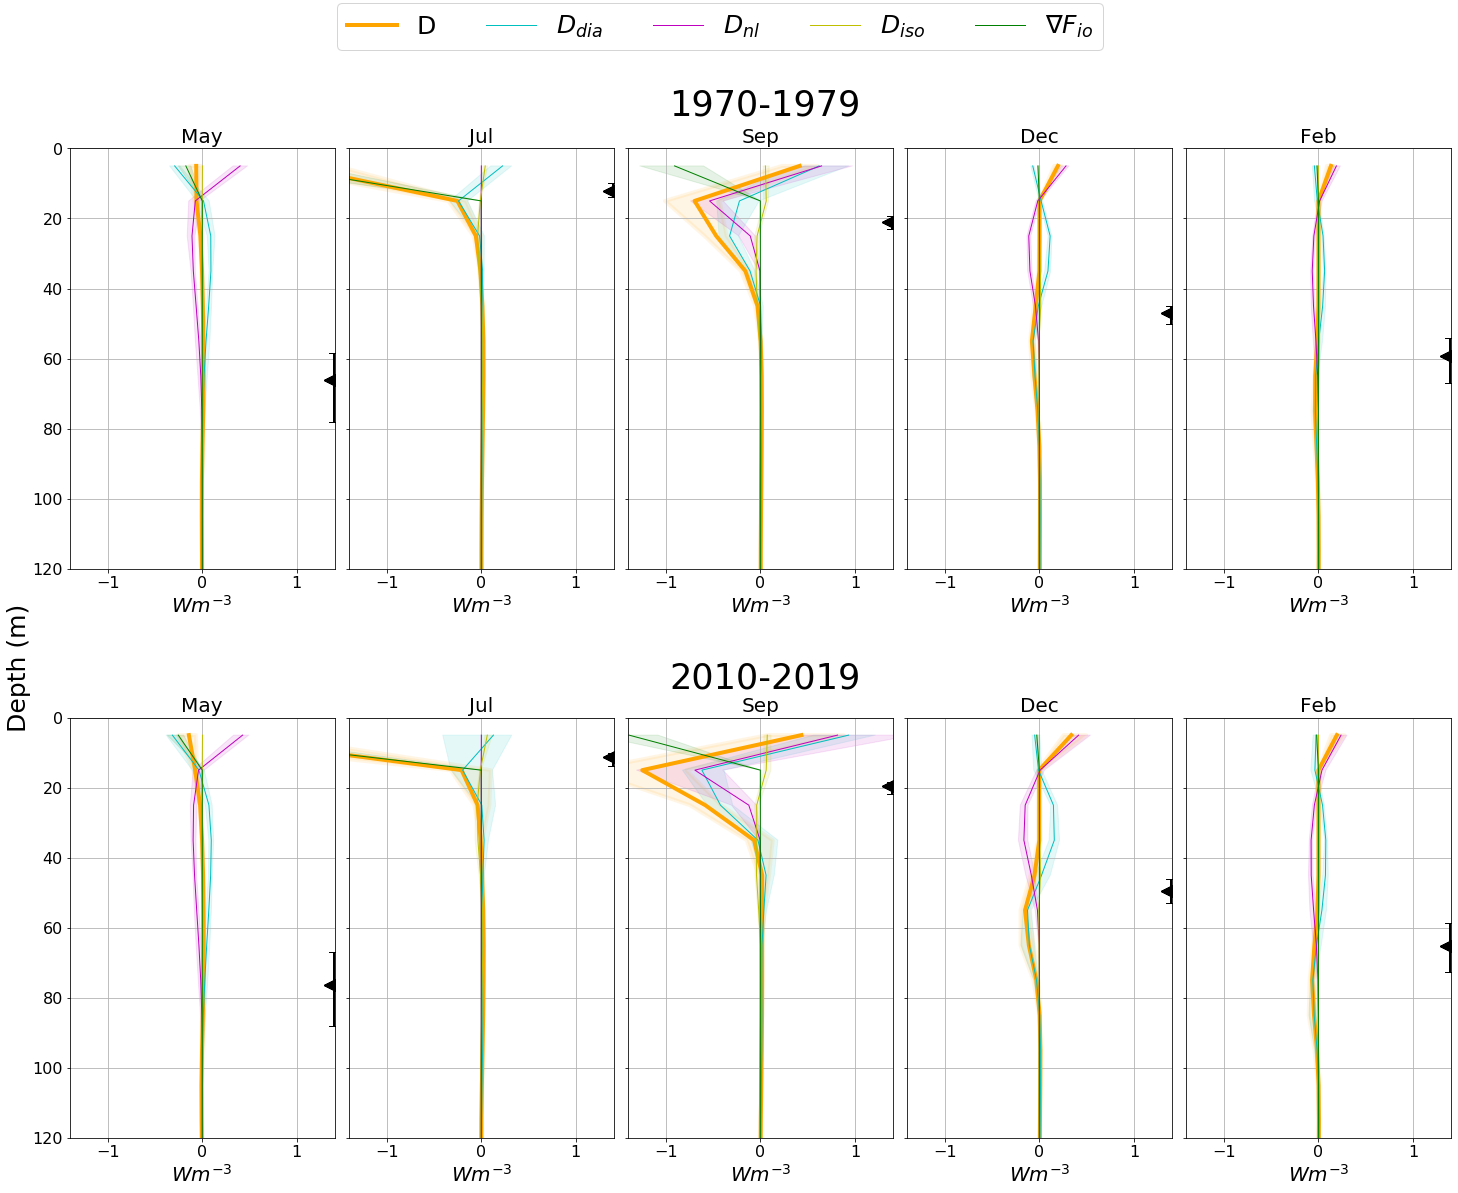

In [8]:
# 70s,10s, diff. 5 months

ylim=(120,0)
xlim=(-1.4,1.4)#
alpha=0.1
fig, axs = plt.subplots(2, 5, figsize=(20,15),sharey=True)
x=0
terms=['D','D_dia', 'D_nl', 'D_h', 'Fio']
labels=['D',r'$D_{dia}$',r'$D_{nl}$',r'$D_{iso}$',r'$\nabla F_{io}$']
colors=['orange','c','m','y','g']
linestyle=['-','-','-','-','-']
linewidths=[4,1,1,1,1]
for monthInd in [4,6,8,11,1]:
    axs[0][x].grid()
    axs[1][x].grid()
    for f, label,c,ls,lw in zip(terms,labels,colors,linestyle,linewidths):
        for p in range(2):
            y=p
            axs[y][x].set_xlabel(r'$W m^{-3}$')

            axs[y][x].plot(transportMean[p][f][monthInd],z_t,color=c,linewidth=lw,linestyle=ls,
                           label=label if monthInd==1 and p==0 else None)
            axs[y][x].fill_betweenx(z_t,transportMin[p][f][monthInd],transportMax[p][f][monthInd],color=c
                                    ,linewidth=lw,linestyle=ls,alpha=alpha)

            axs[y][x].errorbar(xlim[1]-0.01,CESMmean[p]['MLD'][monthInd],yerr=
                               np.reshape([(CESMmean[p]['MLD'][monthInd]-CESMmin[p]['MLD'][monthInd]),
                                (CESMmax[p]['MLD'][monthInd]-CESMmean[p]['MLD'][monthInd])], (2,1))
                               ,fmt='<',color='black',markersize=20,capsize=5)
            axs[y][x].set_xlim(xlim)
            axs[y][x].set_title(months[monthInd],fontsize=20)

    x+=1
fig.legend(ncol=6,bbox_to_anchor=(0.5,1.08),loc='center',fontsize=25)
plt.gca().invert_yaxis()
plt.ylim(ylim)
fig.text(-0.01, 0.49, 'Depth (m)', va='center', rotation='vertical',fontsize=25)
fig.text(0.45, 0.48, '2010-2019', va='center',fontsize=35)
fig.text(0.45, 1.01, '1970-1979', va='center',fontsize=35)
fig.tight_layout(h_pad=8)


# horizontal

In [9]:
"""
#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std
horizontal_40=[{'adv':[],'diff':[]},{'adv':[],'diff':[]}]
varByPro['adv']=['UET','VNT']
varByPro['diff']=['HDIFE_TEMP','HDIFN_TEMP']

horizontalMean=[]
horizontalStd=[]
horizontalMax=[]
horizontalMin=[]
bs,cs=np.where(maskCBice == 1)
for p in range(2):# iterate between 2 periods
    if p==0:
        indA,indB=ind1970,ind1980
        run='B20TRC5CNBDRD'
    else:
        indA,indB=ind2010,ind2020
        run='BRCP85C5CNBDRD'  
    for em in EM[1::]:
        print(em)
        for f in horizontal_40[p]:
            varNeeded=[]
            for var in varByPro[f]:
                #specifics of filename
                model='pop'
                varHemi=var
                if var[0].islower():
                    model='cice'
                    varHemi=var+'_nh'#add hemisphere for name of file
                push1920=0
                if p==0:
                    if em=='001':
                        date='185001-200512'
                        push1920=840#push index to start at 1920 not 1850
                    else:
                        date='192001-200512'          
                else:
                    if int(em)>=34 and p==1:
                        date='200601-210012'
                    else:
                        date='200601-208012'
                fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
                cutVar=fileEM[var][indA+push1920:indB+push1920,:,-104:]# cut like this because it is faster
                varNeeded.append(cutVar)# dont cut CB right now
        
        
            if f=='adv':
                sign=+1
            elif f=='diff':
                sign=-1
            x_indiv=[]
            y_indiv=[]
            for x,y in zip(bs,cs):
            # here we are doing flux before cell - flux after cell
            # gradient would be after- before
            # advection is define as - gradient 
            # we are calculating adv directly.
                x_indiv.append(sign*(varNeeded[0][:,:,x,y-1]-varNeeded[0][:,:,x,y]))
                y_indiv.append(sign*(varNeeded[1][:,:,x-1,y]-varNeeded[1][:,:,x,y]))
            x_indiv=np.array(x_indiv)
            y_indiv=np.array(y_indiv)
            x_indiv=np.swapaxes([x_indiv[:,m::12] for m in range(12)],1,2)*T2E
            y_indiv=np.swapaxes([y_indiv[:,m::12] for m in range(12)],1,2)*T2E

            data_CB_all=x_indiv+y_indiv
                

            horizontal_40[p][f].append(np.nanmean(data_CB_all,axis=(1,2)))
        

    
    for f in horizontal_40[p]:
        horizontal_40[p][f]=np.array(horizontal_40[p][f])
    
    horizontal_40[p]['sum']=horizontal_40[p]['adv']+horizontal_40[p]['diff']
    horizontal_40[p]['residualHor']=transport_40[p]['residual']-horizontal_40[p]['sum']

    meanP={}
    stdP={}
    maxP={}
    minP={}
    for f in horizontal_40[p]:
        meanP[f]=np.nanmean(horizontal_40[p][f],axis=0)
        stdP[f]=np.nanstd(horizontal_40[p][f],axis=0)
        maxP[f]=np.nanmax(horizontal_40[p][f],axis=0)
        minP[f]=np.nanmin(horizontal_40[p][f],axis=0)
    horizontalMean.append(meanP)
    horizontalStd.append(stdP)
    horizontalMax.append(maxP)
    horizontalMin.append(minP)

    """

"\n#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std\nhorizontal_40=[{'adv':[],'diff':[]},{'adv':[],'diff':[]}]\nvarByPro['adv']=['UET','VNT']\nvarByPro['diff']=['HDIFE_TEMP','HDIFN_TEMP']\n\nhorizontalMean=[]\nhorizontalStd=[]\nhorizontalMax=[]\nhorizontalMin=[]\nbs,cs=np.where(maskCBice == 1)\nfor p in range(2):# iterate between 2 periods\n    if p==0:\n        indA,indB=ind1970,ind1980\n        run='B20TRC5CNBDRD'\n    else:\n        indA,indB=ind2010,ind2020\n        run='BRCP85C5CNBDRD'  \n    for em in EM[1::]:\n        print(em)\n        for f in horizontal_40[p]:\n            varNeeded=[]\n            for var in varByPro[f]:\n                #specifics of filename\n                model='pop'\n                varHemi=var\n                if var[0].islower():\n                    model='cice'\n                    varHemi=var+'_nh'#add hemisphere for name of file\n                push1920=0\n                if p==0:\n                    i

In [10]:
"""
with open('saved/horizontalMean.pickle', 'wb') as handle:
    pickle.dump(horizontalMean, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('saved/horizontalStd.pickle', 'wb') as handle:
    pickle.dump(horizontalStd, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved/horizontalMax.pickle', 'wb') as handle:
    pickle.dump(horizontalMax, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('saved/horizontalMin.pickle', 'wb') as handle:
    pickle.dump(horizontalMin, handle, protocol=pickle.HIGHEST_PROTOCOL)

"""

with open('saved/horizontalMean.pickle', 'rb') as handle:
    horizontalMean = pickle.load(handle)

with open('saved/horizontalStd.pickle', 'rb') as handle:
    horizontalStd = pickle.load(handle)
with open('saved/horizontalMax.pickle', 'rb') as handle:
    horizontalMax = pickle.load(handle)

with open('saved/horizontalMin.pickle', 'rb') as handle:
    horizontalMin = pickle.load(handle)


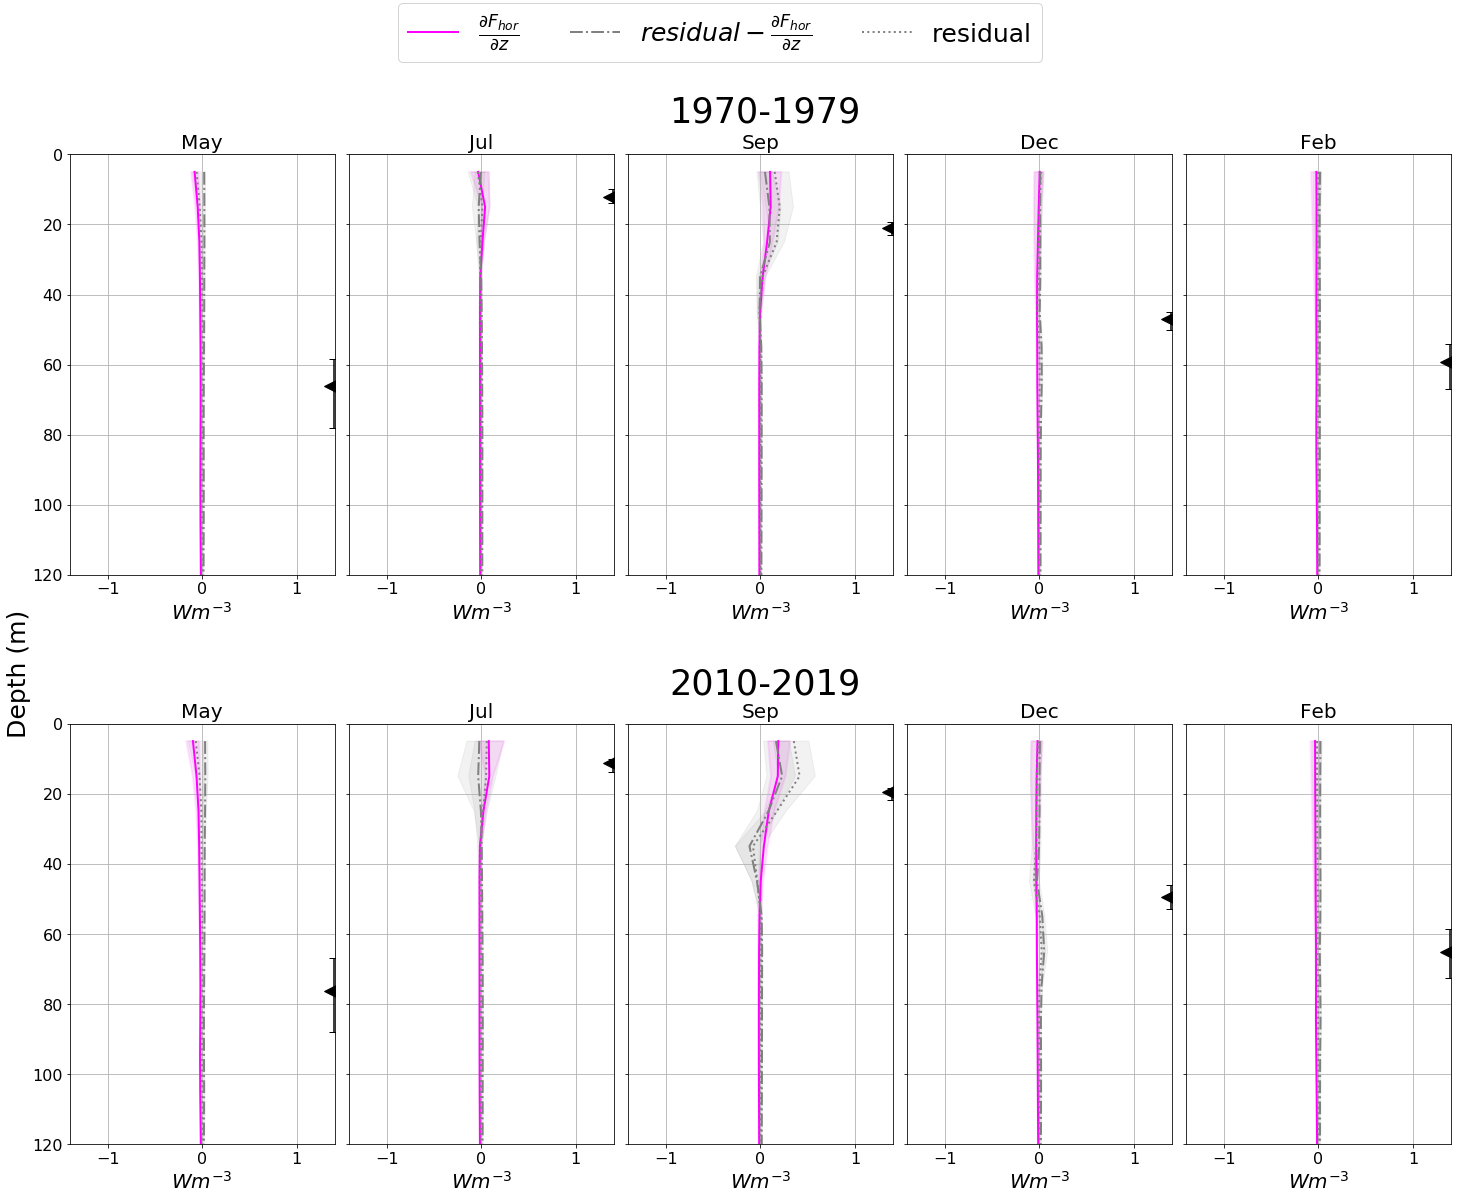

In [11]:
# 70s,10s, diff. 5 months

ylim=(120,0)
xlim=(-1.4,1.4)#
alpha=0.1
fig, axs = plt.subplots(2, 5, figsize=(20,15),sharey=True)
x=0

lw=2
for monthInd in [4,6,8,11,1]:
    axs[0][x].grid()
    axs[1][x].grid()
    for p in range(2):
        y=p
        axs[y][x].set_xlabel(r'$W m^{-3}$')

        axs[y][x].plot(horizontalMean[p]['sum'][monthInd],z_t,color='fuchsia',linewidth=lw,linestyle='-',
                       label=r'$\frac{\partial F_{hor}}{\partial z}$' if monthInd==1 and p==0 else None)
        axs[y][x].fill_betweenx(z_t,horizontalMin[p]['sum'][monthInd],horizontalMax[p]['sum'][monthInd],color='fuchsia'
                                ,linewidth=lw,alpha=alpha)
        
        axs[y][x].plot(horizontalMean[p]['residualHor'][monthInd],z_t,color='grey',linewidth=lw,linestyle='-.',
                       label=r'$residual -\frac{\partial F_{hor}}{\partial z}$' if monthInd==1 and p==0 else None)
        axs[y][x].fill_betweenx(z_t,horizontalMin[p]['residualHor'][monthInd],horizontalMax[p]['residualHor'][monthInd]
                                ,color='grey',alpha=alpha)
        
        axs[y][x].plot(transportMean[p]['residual'][monthInd],z_t,color='grey',linewidth=lw,linestyle=':',
                       label=r'residual' if monthInd==1 and p==0 else None)
        axs[y][x].fill_betweenx(z_t,transportMin[p]['residual'][monthInd],transportMax[p]['residual'][monthInd]
                                ,color='grey',alpha=alpha)

        axs[y][x].errorbar(xlim[1]-0.01,CESMmean[p]['MLD'][monthInd],yerr=
                           np.reshape([(CESMmean[p]['MLD'][monthInd]-CESMmin[p]['MLD'][monthInd]),
                            (CESMmax[p]['MLD'][monthInd]-CESMmean[p]['MLD'][monthInd])], (2,1))
                           ,fmt='<',color='black',markersize=20,capsize=5)
        axs[y][x].set_xlim(xlim)
        axs[y][x].set_title(months[monthInd],fontsize=20)

    x+=1
fig.legend(ncol=6,bbox_to_anchor=(0.5,1.08),loc='center',fontsize=25)
plt.gca().invert_yaxis()
plt.ylim(ylim)
fig.text(-0.01, 0.49, 'Depth (m)', va='center', rotation='vertical',fontsize=25)
fig.text(0.45, 0.48, '2010-2019', va='center',fontsize=35)
fig.text(0.45, 1.01, '1970-1979', va='center',fontsize=35)
fig.tight_layout(h_pad=8)
